In [118]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import t

In [119]:
ticker = 'SPY'

data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

col = "Adj Close" if "Adj Close" in data.columns else "Close"
prices = data[col]
print("Using:", col)

print(prices.head())


C:\Users\Admin\AppData\Local\Temp\ipykernel_12616\935606481.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed

Using: Close
Ticker             SPY
Date                  
2020-01-02  298.578583
2020-01-03  296.317719
2020-01-06  297.448242
2020-01-07  296.611877
2020-01-08  298.192688


In [120]:
log_returns = np.log(1 + prices.pct_change())
mu = log_returns.mean()
sigma = log_returns.std()

# Ensure mu and sigma are scalars to avoid broadcasting errors
if isinstance(mu, pd.Series):
    mu = mu.item()
if isinstance(sigma, pd.Series):
    sigma = sigma.item()

last_price = prices.iloc[-1]
if isinstance(last_price, pd.Series):
    last_price = last_price.item()

num_simulations = 10000
num_days = 252

In [121]:


rng = np.random.default_rng(3)
random_shocks = rng.normal(0, 1, (num_days, num_simulations))
#drift = (mu - 0.5 * sigma**2)
#diffusion = sigma * random_shocks

daily_returns_sim = np.exp(mu + sigma * random_shocks)
price_paths = np.zeros_like(daily_returns_sim)
price_paths[0] = last_price
daily_returns_sim[0] = 1.0
price_paths[1:] = last_price * np.cumprod(daily_returns_sim[1:], axis=0)
#############################################################################################
df = 5

# Generate random shocks using Student-t distribution
random_shocks_t = rng.standard_t(df, (num_days, num_simulations))

# Variance of t-dist is df / (df - 2) for df > 2
scaling_factor = np.sqrt((df - 2) / df)
random_shocks_t_scaled = random_shocks_t * scaling_factor

#diffusion_t = sigma * random_shocks_t_scaled
#drift_t = (mu - 0.5 * sigma**2)


daily_returns_sim_t = np.exp( mu+sigma*random_shocks_t_scaled)
price_paths_t = np.zeros_like(daily_returns_sim_t)
price_paths_t[0] = last_price
#daily_returns_sim_t[0] = 1.0
price_paths_t[1:] = last_price * np.cumprod(daily_returns_sim_t[1:], axis=0)


In [122]:
# ความเชื่อมั่น 99.9% (เหตุการณ์ร้ายแรงที่เกิด 1 ใน 1000 ครั้ง)
# percentile 0.1 คือตัดเอาหางซ้ายสุดๆ มาดู
loss_normal = np.percentile(price_paths, 0.1) 
loss_t = np.percentile(price_paths_t, 0.1) 

print(f"Normal Model บอกว่าแย่สุดหุ้นจะเหลือ: {loss_normal:.2f}")
print(f"Student-t Model บอกว่าแย่สุดหุ้นจะเหลือ: {loss_t:.2f}")
print(f"ส่วนต่าง: {loss_normal - loss_t:.2f}")

Normal Model บอกว่าแย่สุดหุ้นจะเหลือ: 287.23
Student-t Model บอกว่าแย่สุดหุ้นจะเหลือ: 283.25
ส่วนต่าง: 3.98


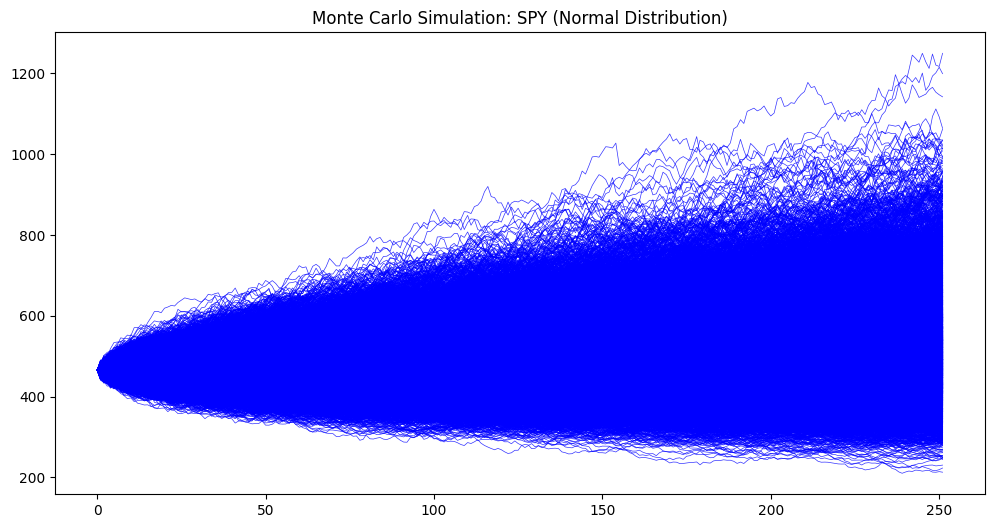

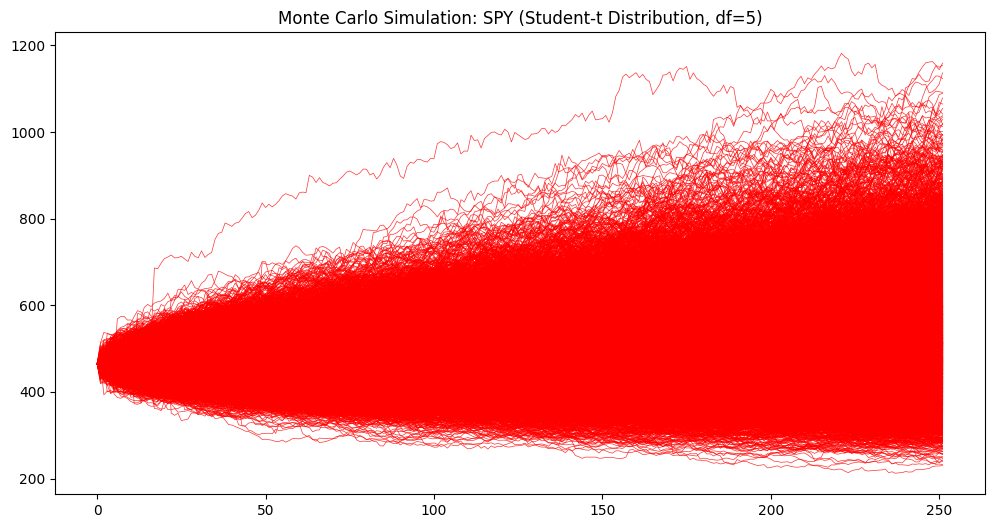

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(price_paths, color='blue', alpha=0.8, linewidth=0.5)
plt.title("Monte Carlo Simulation: SPY (Normal Distribution)")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(price_paths_t, color='red', alpha=0.8, linewidth=0.5)
plt.title(f"Monte Carlo Simulation: SPY (Student-t Distribution, df={df})")
plt.show()



usable n = 1005


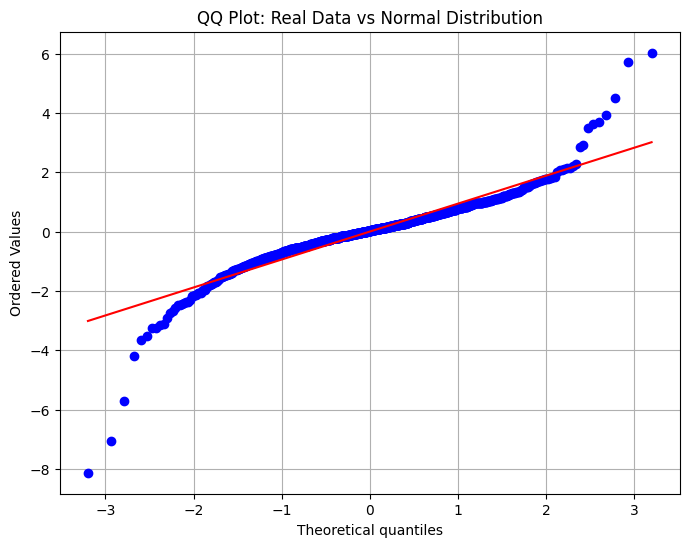

In [124]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

ret_clean = log_returns.dropna()

# ทำให้เป็น 1D จริง ๆ
x = ret_clean.squeeze()
if isinstance(x, pd.DataFrame):      # กรณีมีหลายคอลัมน์ เลือกคอลัมน์ที่ต้องการ
    x = x.iloc[:, 0]

x = x.astype(float).to_numpy()

# Standardize
x = (x - np.mean(x)) / np.std(x, ddof=1)

# เอาเฉพาะค่าที่เป็นตัวเลขจริง
x = x[np.isfinite(x)]

print("usable n =", x.size)  # <- ต้อง >= 2

if x.size < 2:
    raise ValueError("std_rets เหลือน้อยกว่า 2 จุด: ตรวจว่า log_returns สร้างถูกไหม/ข้อมูลมีพอไหม")

plt.figure(figsize=(8, 6))
stats.probplot(x, dist="norm", plot=plt)
plt.title("QQ Plot: Real Data vs Normal Distribution")
plt.grid(True)
plt.show()


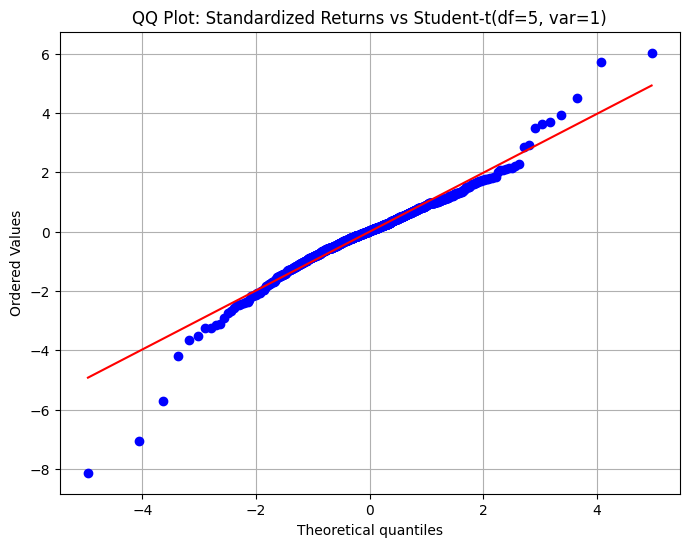

In [125]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# --- prepare 1D clean data ---
ret_clean = log_returns.dropna().squeeze()
if isinstance(ret_clean, pd.DataFrame):
    ret_clean = ret_clean.iloc[:, 0]

x = ret_clean.astype(float).to_numpy()
x = x[np.isfinite(x)]
if x.size < 2:
    raise ValueError("ข้อมูลน้อยกว่า 2 จุด ใช้ QQ plot ไม่ได้")

# Standardize => mean=0, std=1
z = (x - x.mean()) / x.std(ddof=1)
z = z[np.isfinite(z)]

# --- Student-t QQ plot ---
df = 5
# ทำให้ t มี variance = 1  (เพราะ Var(t)=df/(df-2) เมื่อ scale=1)
scale = np.sqrt((df - 2) / df)

plt.figure(figsize=(8, 6))
stats.probplot(z, dist=stats.t, sparams=(df, 0, scale), plot=plt)
plt.title(f"QQ Plot: Standardized Returns vs Student-t(df={df}, var=1)")
plt.grid(True)
plt.show()


In [ ]:

test_data = yf.download('SPY', start='2024-01-01', end='2024-12-31', auto_adjust=True)
actual_prices = test_data['Close'].values[:252] # ตัดให้จำนวนวันเท่ากับ Simulation


plt.figure(figsize=(12, 7))

plt.plot(price_paths_t[:, :10000], color='red', alpha=0.1, linewidth=0.5) 


plt.plot(actual_prices, color='black', linewidth=2.5, label='ACTUAL 2024 Price')


plt.title("Reality Check: Simulation vs Actual 2024 Market Data")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


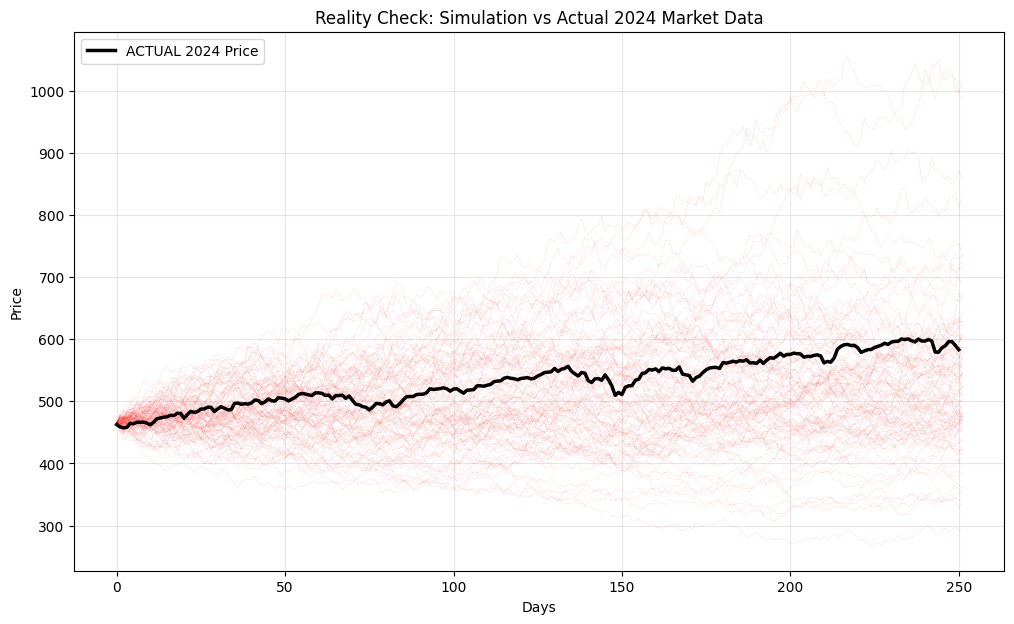

In [ ]:

test_data = yf.download('SPY', start='2024-01-01', end='2024-12-31', auto_adjust=True)
actual_prices = test_data['Close'].values[:252] # ตัดให้จำนวนวันเท่ากับ Simulation


plt.figure(figsize=(12, 7))


plt.plot(price_paths[:, :10000], color='red', alpha=0.1, linewidth=0.5) 


plt.plot(actual_prices, color='black', linewidth=2.5, label='ACTUAL 2024 Price')

plt.title("Reality Check: Simulation vs Actual 2024 Market Data")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

VaR99 (Normal): 157.76
ES99  (Normal): 179.73
VaR99 (t):      159.92
ES99  (t):      181.44


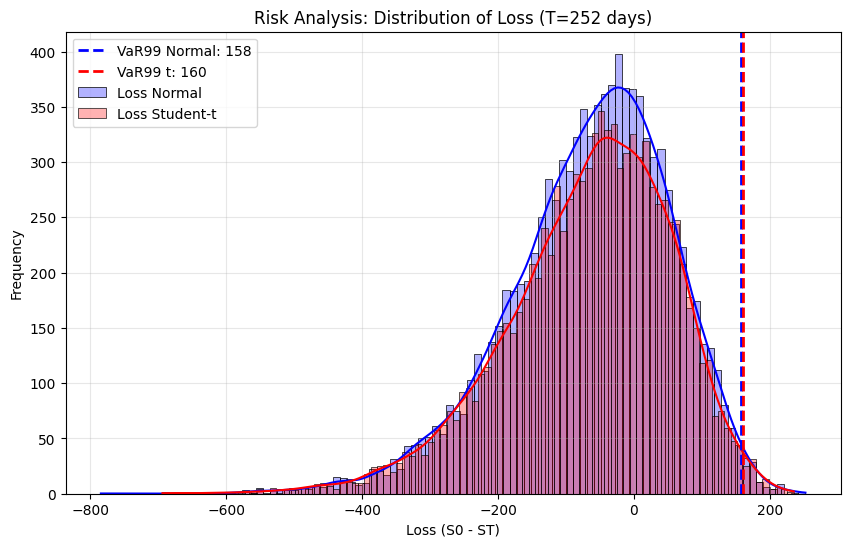

In [ ]:
import seaborn as sns
S0 = last_price

ST_normal = price_paths[-1]
ST_t      = price_paths_t[-1]

loss_normal = S0 - ST_normal
loss_t      = S0 - ST_t

VaR99_normal = np.quantile(loss_normal, 0.99)
VaR99_t      = np.quantile(loss_t, 0.99)

ES99_normal = loss_normal[loss_normal >= VaR99_normal].mean()
ES99_t      = loss_t[loss_t >= VaR99_t].mean()

print(f"VaR99 (Normal): {VaR99_normal:.2f}")
print(f"ES99  (Normal): {ES99_normal:.2f}")
print(f"VaR99 (t):      {VaR99_t:.2f}")
print(f"ES99  (t):      {ES99_t:.2f}")
plt.figure(figsize=(10,6))
sns.histplot(loss_normal, bins=100, color='blue', alpha=0.3, label='Loss Normal', kde=True)
sns.histplot(loss_t, bins=100, color='red',  alpha=0.3, label='Loss Student-t', kde=True)

plt.axvline(VaR99_normal, color='blue', linestyle='--', linewidth=2, label=f'VaR99 Normal: {VaR99_normal:.0f}')
plt.axvline(VaR99_t,      color='red',  linestyle='--', linewidth=2, label=f'VaR99 t: {VaR99_t:.0f}')

plt.title(f"Risk Analysis: Distribution of Loss (T={num_days} days)")
plt.xlabel("Loss (S0 - ST)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
